In [155]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

from nltk.corpus import stopwords
from tqdm import tqdm
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack

from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

In [2]:
# training/training_variants is a comma separated file containing the description of the genetic mutations used for training.
# Fields are :

# ID : the id of the row used to link the mutation to the clinical evidence <\br>
# Gene : the gene where this genetic mutation is located <\br>
# Variation : the aminoacid change for this mutations <\br>
# Class : 1-9 the class this genetic mutation has been classified on <\br>


data = pd.read_csv("../input/msk-redefining-cancer-treatment/training_variants.zip")
print("Number of data points : ", data.shape[0])
print("Number of features : ", data.shape[1])
print("Features : ", data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
data_text = pd.read_csv("../input/msk-redefining-cancer-treatment/training_text.zip", sep = "\|\|", engine = "python", names = ["ID", "Text"], skiprows=1)
print("Number of data points : ", data_text.shape[0])
print("Number of features : ", data_text.shape[1])
print("Features : ", data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'Text']


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [4]:
# Merging both gene variation and text data based on "ID"

df = pd.merge(data, data_text, on = 'ID', how = 'left')
df.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
df.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
Text         5
dtype: int64

We can see "Text" column has 5 missing values.

In [6]:
df[df.isnull().any(axis = 1)]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [7]:
# Replacing NaN with Gene + Variation

df.loc[df['Text'].isnull(),'Text'] = df['Gene'] +' '+df['Variation']

In [8]:
df.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
Text         0
dtype: int64

In [9]:
# How it looks after replacing NaN with Gene+Variation ?

df[df['ID'] == 1277]

,ID,Gene,Variation,Class,Text
1277,1277,ARID5B,Truncating Mutations,1,ARID5B Truncating Mutations


## Preprocessing of text

In [10]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
stopwords = set(stopwords.words('english'))

def nlp_preprocessing(text):
    string = ""
    # replace every special char with space
    text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
    
    # replacing multiple spaces with single space
    text = re.sub('\s+', ' ', text)
    
    # Converting all the characters into lower-case
    text = text.lower()
    
    for word in text.split():
        # if the word is a not a stop word then retain that word from the data
        if word not in stopwords:
            string += word + " "
    return string

In [12]:
df['Text'] = df['Text'].progress_apply(nlp_preprocessing)

  0%|          | 0/3321 [00:00<?, ?it/s]

## Test, Train and Cross Validation Split


Splitting data into train, test and cross validation (64:20:16)

In [13]:
y_true = df.Class.values

# Replacing spaces between words by underscores as Gene and Variation name should occur as it is
df.Gene = df.Gene.str.replace("\s+", '_')  
df.Variation = df.Variation.replace("\s+", "_")



# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [14]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_val.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


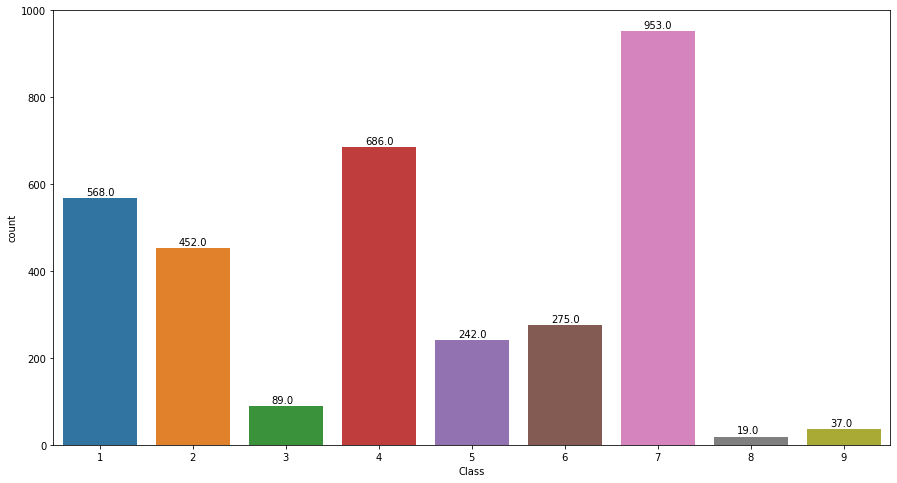

In [15]:
# Distribution of classes in the data
plt.figure(figsize=(15,8))
ax = sns.countplot(x = df['Class'])

for p in ax.patches: 
    ax.annotate('{:.1f}'.format(p.get_height().astype(int)), (p.get_x()+0.25, p.get_height()+7)) 
plt.show()

#  Prediction using a 'Random' Model

>In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1.

In [16]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    
    
    labels = [1,2, 3, 4, 5, 6, 7, 8, 9]
    # representing A in heatmap format
    #cmap=sns.light_palette("blue")
    #plt.subplot(1, 3, 1)
    plt.figure(figsize=(20,4))
    sns.heatmap(C, annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    plt.show()
    
    #plt.subplot(1, 3, 2)
    plt.figure(figsize=(20,4))
    sns.heatmap(B, annot=True, cmap='Blues', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    plt.show()
    
    #plt.subplot(1, 3, 3)
    plt.figure(figsize=(20,4))
    # representing B in heatmap format
    sns.heatmap(A, annot=True, vmin=0, vmax=0.5, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Cross Validation Data using Random Model 2.431934836953095


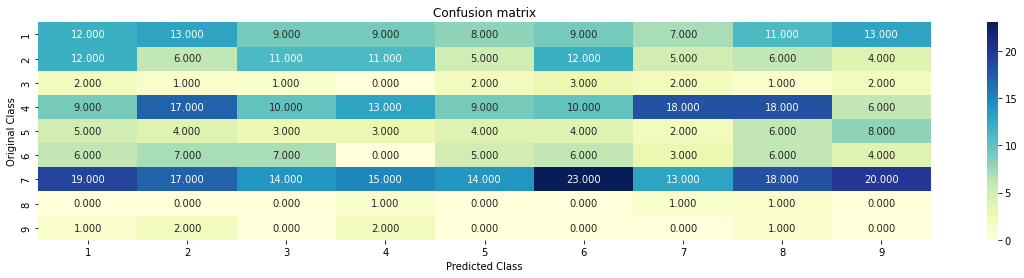

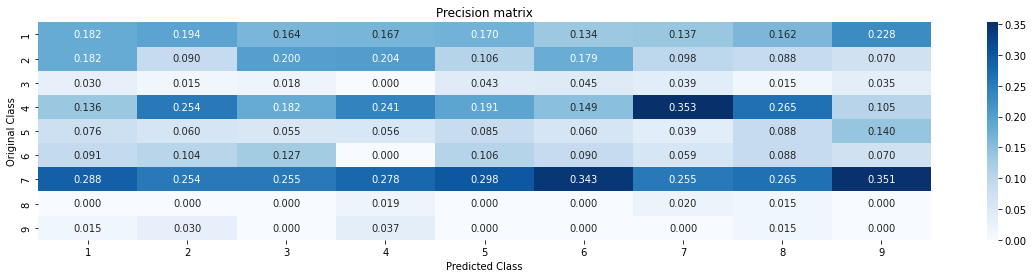

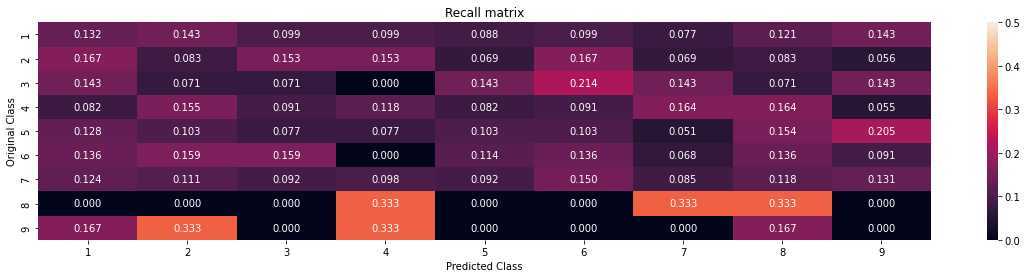

In [17]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum

len_of_cv = X_val.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted = np.zeros((len_of_cv, 9))

for i in range(len_of_cv):
    rand_prob = np.random.rand(1,9)   # generating random numbers for all 9 classes
    cv_predicted[i] = ((rand_prob / sum(sum(rand_prob)))[0])  # As we are working with probabilities, sum of all probabilites should be 1.
    
cv_ypred = np.argmax(cv_predicted, axis = 1) + 1 # Storing index of max value. Adding 1 because index starts with 0 but our classes range from 1-9
print("Log loss on Cross Validation Data using Random Model",log_loss(X_val['Class'],cv_predicted, eps=1e-15))
plot_confusion_matrix(X_val['Class'], cv_ypred)

Log loss on Cross Validation Data using Random Model 2.416911236901913


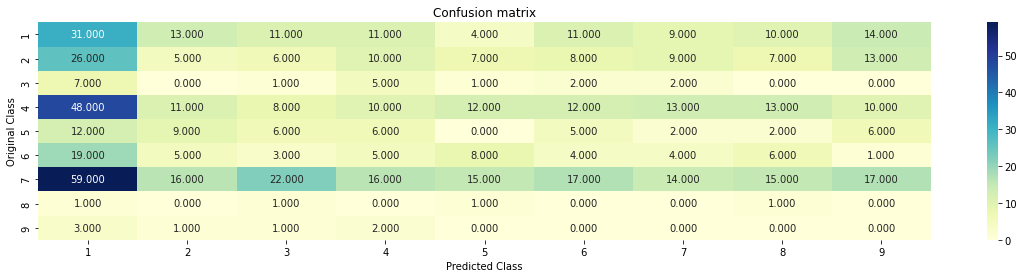

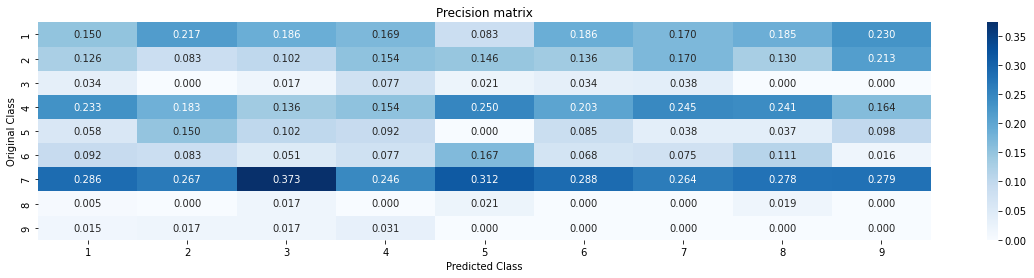

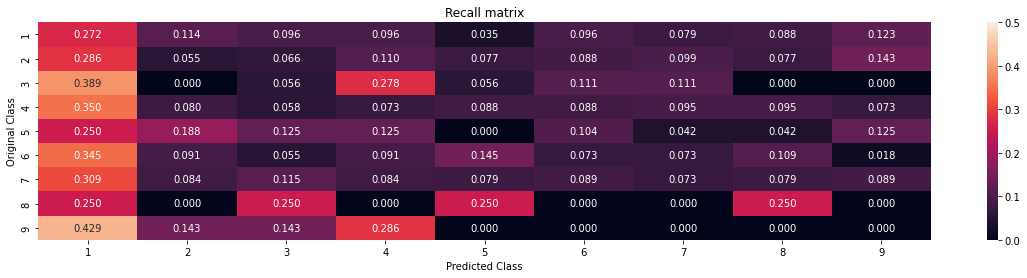

In [18]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum

len_of_test = X_test.shape[0]

# we create a output array that has exactly same size as the "Test" data
xtest_predicted = np.zeros((len_of_test, 9))

for i in range(len_of_cv):
    rand_prob = np.random.rand(1,9)   # generating random numbers for all 9 classes
    xtest_predicted[i] = ((rand_prob / sum(sum(rand_prob)))[0])  # As we are working with probabilities, sum of all probabilites should be 1.
    
xtest_ypred = np.argmax(xtest_predicted, axis = 1) + 1 # Storing index of max value. Adding 1 because index starts with 0 but our classes range from 1-9
print("Log loss on Cross Validation Data using Random Model",log_loss(X_test['Class'],xtest_predicted, eps=1e-15))
plot_confusion_matrix(X_test['Class'], xtest_ypred)

## Univeriate Analysis

### Univariate Analysis on Gene Feature

Q1. Gene, What type of feature it is ?

Ans. Gene is a categorical variable

Q2. How many categories are there and How they are distributed?

In [19]:
unique_genes = df['Gene'].value_counts()
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the data, and they are distibuted as follows: ")
# the top 10 genes that occured most
print(unique_genes.head(10))

Ans: There are 264 different categories of genes in the data, and they are distibuted as follows: 
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ALK        69
ERBB2      69
PDGFRA     60
Name: Gene, dtype: int64


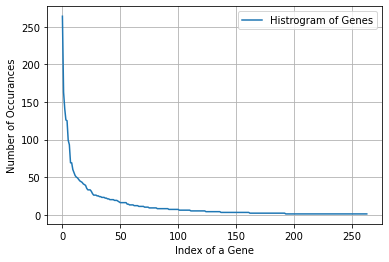

In [20]:
s = sum(unique_genes.values);
h = unique_genes.values
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

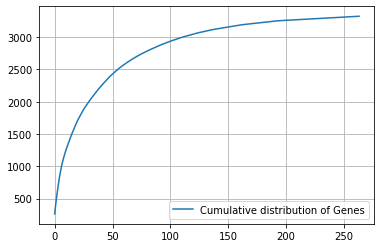

In [21]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

Q3. How to featurize this Gene feature ?

Ans. There are two ways we can featurize this variable:

    1. One hot Encoding
    2. Response coding

We will choose the appropriate featurization based on the ML model we use. For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests.

### 1. One-Hot Encoding

In [22]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(X_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(X_val['Gene'])

In [23]:
gene_vectorizer.get_feature_names_out()

array(['abl1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc', 'ar', 'araf',
       'arid1a', 'arid1b', 'arid5b', 'asxl1', 'atm', 'atrx', 'aurka',
       'aurkb', 'b2m', 'bap1', 'bard1', 'bcl10', 'bcl2l11', 'bcor',
       'braf', 'brca1', 'brca2', 'brd4', 'brip1', 'btk', 'card11',
       'carm1', 'casp8', 'cbl', 'ccnd1', 'ccnd2', 'ccnd3', 'ccne1',
       'cdh1', 'cdk12', 'cdk4', 'cdk6', 'cdk8', 'cdkn1a', 'cdkn1b',
       'cdkn2a', 'cdkn2b', 'cebpa', 'chek2', 'cic', 'crebbp', 'ctcf',
       'ctnnb1', 'ddr2', 'dicer1', 'dnmt3a', 'dnmt3b', 'egfr', 'elf3',
       'ep300', 'epas1', 'epcam', 'erbb2', 'erbb3', 'erbb4', 'ercc2',
       'ercc3', 'ercc4', 'erg', 'errfi1', 'esr1', 'etv1', 'etv6', 'ewsr1',
       'ezh2', 'fam58a', 'fanca', 'fancc', 'fat1', 'fbxw7', 'fgf3',
       'fgf4', 'fgfr1', 'fgfr2', 'fgfr3', 'fgfr4', 'flt3', 'foxa1',
       'foxl2', 'foxo1', 'foxp1', 'gata3', 'gna11', 'gnaq', 'gnas',
       'h3f3a', 'hist1h1c', 'hla', 'hnf1a', 'hras', 'idh1', 'idh2',
       'igf1r', 'ikbke', '

In [24]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 232)


In [25]:
X_train['Gene'].value_counts()

BRCA1    178
TP53      96
EGFR      94
PTEN      78
BRCA2     69
        ... 
U2AF1      1
RXRA       1
FGF4       1
SHOC2      1
STAG2      1
Name: Gene, Length: 232, dtype: int64

In [26]:
df['Gene'].value_counts()

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
         ... 
RYBP        1
MDM2        1
CTLA4       1
ARID1A      1
FAM58A      1
Name: Gene, Length: 264, dtype: int64

In [27]:
len(set(df.Gene))

264

### 2. Below code performs Respose Coding using Laplace smoothing..

In [28]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        #print(i, denominator)
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 dimensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = df.loc[(df['Class']==k) & (df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in current class
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    
    
    
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    #print(gv_dict)
    # value_count is similar in get_gv_fea_dict
    value_count = df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [29]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_train))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_test))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_val))

In [30]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)
print("test_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", test_gene_feature_responseCoding.shape)
print("cv_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", cv_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)
test_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (665, 9)
cv_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (532, 9)


Q4. How good is this gene feature in predicting y_i?

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

In [31]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

For values of alpha =  1e-05 The log loss is: 1.2614883896622957
For values of alpha =  0.0001 The log loss is: 1.2287873118839476
For values of alpha =  0.001 The log loss is: 1.2507118677213973
For values of alpha =  0.01 The log loss is: 1.3451138280261443
For values of alpha =  0.1 The log loss is: 1.4690991039376877
For values of alpha =  1 The log loss is: 1.513320849970303


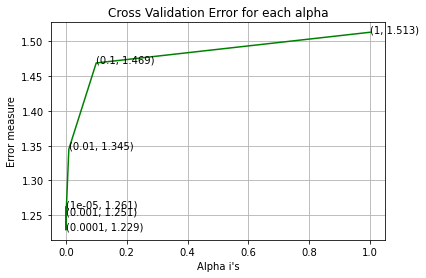

In [32]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha = i, penalty = 'l2', loss = 'log', random_state = 42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_val, predict_y, labels = clf.classes_, eps = 1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
    

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [33]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)


predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.9942590376533991
For values of best alpha =  0.0001 The cross validation log loss is: 1.2287873118839476
For values of best alpha =  0.0001 The test log loss is: 1.1482487216549955


Q5. Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?

Ans. Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error.

In [34]:
X_test['Gene'].value_counts()

BRCA1    53
TP53     41
BRCA2    32
PTEN     25
KIT      23
         ..
GLI1      1
ERCC4     1
GNAS      1
YAP1      1
CIC       1
Name: Gene, Length: 149, dtype: int64

In [35]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=X_test[X_test['Gene'].isin(list(set(X_train['Gene'])))].shape[0]
cv_coverage=X_val[X_val['Gene'].isin(list(set(X_train['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',X_val.shape[0],":" ,(cv_coverage/X_val.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  264  genes in train dataset?
Ans
1. In test data 647 out of 665 : 97.29323308270676
2. In cross validation data 511 out of  532 : 96.05263157894737


### 3.2.2 Univariate Analysis on Variation Feature
Q7. Variation, What type of feature is it ?

Ans. Variation is a categorical variable

Q8. How many categories are there?


In [36]:
unique_variations = X_train['Variation'].value_counts()
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)
# the top 10 variations that occured most
print(unique_variations.head(10))

Ans: There are 1923 different categories of variations in the train data, and they are distibuted as follows
Truncating Mutations    64
Deletion                48
Amplification           47
Fusions                 20
G12V                     4
Q61H                     3
Overexpression           3
R841K                    2
TMPRSS2-ETV1 Fusion      2
V321M                    2
Name: Variation, dtype: int64


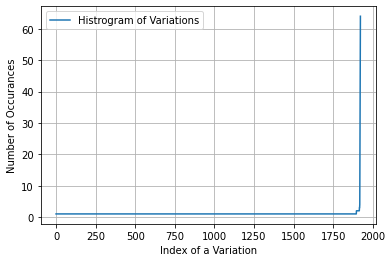

In [37]:
h = sorted(unique_variations.values)
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

It can seen that the plot is highly skewed. That means there are very few number of variation whose occurance is more than 5.

[4.70809793e-04 9.41619586e-04 1.41242938e-03 ... 9.47269303e-01
 9.69868173e-01 1.00000000e+00]


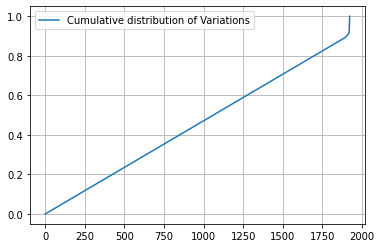

In [38]:
s = sum(unique_variations.values)
h = h/s
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

Q9. How to featurize this Variation feature ?

Ans.There are two ways we can featurize this variable:

    1. One hot Encoding
    2. Response coding
We will be using both these methods to featurize the Variation Feature

In [39]:
# One-Hot Encoding of variation feature.

variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(X_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(X_val['Variation'])

In [40]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1952)


In [41]:
# Response Coding..........


# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", X_train))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", X_test))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", X_val))

In [42]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


Q10. How good is this Variation feature in predicting y_i?

Let's build a model just like the earlier!

For values of alpha =  1e-05 The log loss is: 1.7023347405696563
For values of alpha =  0.0001 The log loss is: 1.6969237844180725
For values of alpha =  0.001 The log loss is: 1.7066185404565797
For values of alpha =  0.01 The log loss is: 1.7188711737835214
For values of alpha =  0.1 The log loss is: 1.7365930746124072
For values of alpha =  1 The log loss is: 1.7383452659825205


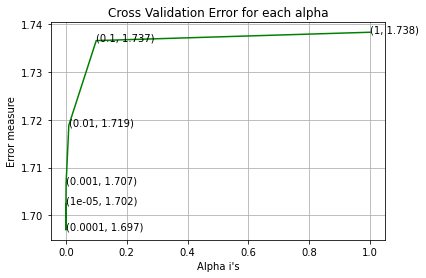

In [43]:
alpha = [10**x for x in range(-5,1)]

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha = i, penalty='l2', loss = 'log', random_state=42, n_jobs = -1)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid", n_jobs = -1)
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_val, predict_y, labels = clf.class_weight, eps = 1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
    
    
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [44]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.0001 The train log loss is: 0.6990128381258112
For values of best alpha =  0.0001 The cross validation log loss is: 1.6969237844180725
For values of best alpha =  0.0001 The test log loss is: 1.70014212014358


Q11. Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?

Ans. Not sure! But lets be very sure using the below analysis.

In [45]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=X_test[X_test['Variation'].isin(list(set(X_train['Variation'])))].shape[0]
cv_coverage=X_val[X_val['Variation'].isin(list(set(X_train['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',X_val.shape[0],":" ,(cv_coverage/X_val.shape[0])*100)

Q12. How many data points are covered by total  1923  genes in test and cross validation data sets?
Ans
1. In test data 59 out of 665 : 8.87218045112782
2. In cross validation data 60 out of  532 : 11.278195488721805


### 3.2.3 Univariate Analysis on Text Feature
1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [46]:
# One-Hot Encoding..........

# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(X_train['Text'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 54533


In [47]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['Text'].split():
            dictionary[word] +=1
    return dictionary

In [48]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['Text'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['Text'].split()))
            row_index += 1
    return text_feature_responseCoding

In [49]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = X_train[X_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is build on whole training text data
total_dict = extract_dictionary_paddle(X_train)



confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)


In [50]:
confuse_array[0]

array([0.12410785, 0.03846154, 0.00674068, 0.29064235, 0.07335448,
       0.32196669, 0.13243458, 0.00475813, 0.0075337 ])

In [51]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(X_train)
test_text_feature_responseCoding  = get_text_responsecoding(X_test)
cv_text_feature_responseCoding  = get_text_responsecoding(X_val)

In [52]:
# we convert each row values such that they sum to 1
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [53]:
train_text_feature_responseCoding

array([[0.14251408, 0.14037103, 0.02755868, ..., 0.37216152, 0.01203977,
        0.01593876],
       [0.17649609, 0.12592391, 0.02637773, ..., 0.2847565 , 0.01766779,
        0.03291937],
       [0.1247868 , 0.18170107, 0.02235583, ..., 0.41766471, 0.01226501,
        0.01545465],
       ...,
       [0.135506  , 0.18307478, 0.02556611, ..., 0.37310899, 0.01467295,
        0.01937636],
       [0.21981697, 0.10638427, 0.02517013, ..., 0.2384386 , 0.01405806,
        0.02142042],
       [0.22231522, 0.13906137, 0.02272036, ..., 0.27162276, 0.01414906,
        0.01828281]])

In [54]:
len(train_text_feature_responseCoding.T)

9

In [55]:
len(train_text_feature_responseCoding.sum(axis=1))

2124

In [56]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(X_test['Text'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(X_val['Text'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [57]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [58]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5600, 4: 3690, 5: 3052, 6: 2863, 7: 2054, 8: 2017, 9: 1915, 10: 1559, 12: 1274, 11: 1210, 13: 1023, 15: 988, 14: 897, 16: 830, 18: 827, 17: 699, 20: 602, 24: 538, 22: 524, 19: 508, 21: 466, 36: 454, 30: 366, 27: 366, 25: 362, 28: 357, 23: 345, 26: 338, 32: 334, 33: 309, 56: 292, 35: 290, 34: 265, 31: 264, 29: 254, 39: 238, 40: 234, 42: 209, 37: 201, 48: 198, 38: 191, 41: 186, 45: 184, 44: 175, 52: 164, 49: 164, 43: 157, 46: 156, 50: 154, 60: 148, 57: 145, 51: 142, 55: 141, 47: 137, 53: 136, 54: 131, 66: 124, 64: 124, 62: 115, 58: 115, 78: 113, 65: 110, 59: 109, 71: 107, 68: 105, 63: 105, 70: 102, 67: 102, 61: 102, 72: 101, 80: 91, 73: 90, 74: 88, 69: 85, 90: 80, 84: 79, 96: 77, 82: 77, 77: 77, 75: 77, 112: 76, 83: 76, 88: 72, 104: 70, 76: 70, 85: 69, 86: 67, 92: 66, 81: 66, 79: 64, 87: 63, 89: 60, 94: 59, 109: 58, 95: 58, 105: 56, 93: 56, 100: 54, 97: 54, 91: 54, 103: 53, 108: 51, 128: 50, 106: 50, 101: 49, 126: 47, 125: 47, 115: 47, 111: 47, 120: 46, 110: 45, 98: 45, 99: 4

For values of alpha =  1e-05 The log loss is: 1.3390944330734311
For values of alpha =  0.0001 The log loss is: 1.1392295418562248
For values of alpha =  0.001 The log loss is: 1.1500500396764861
For values of alpha =  0.01 The log loss is: 1.2707322585653114
For values of alpha =  0.1 The log loss is: 1.4780161160399918
For values of alpha =  1 The log loss is: 1.6792898760955572


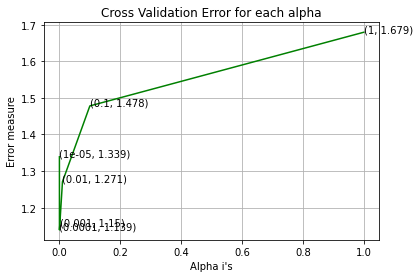

In [59]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(loss = 'log', penalty = 'l2', alpha = i, n_jobs = -1)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_val, predict_y, labels= clf.classes_, eps = 1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
    
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [60]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.6679560025979728
For values of best alpha =  0.0001 The cross validation log loss is: 1.1377312511784143
For values of best alpha =  0.0001 The test log loss is: 1.1230938046956849


Q. Is the Text feature stable across all the data sets (Test, Train, Cross validation)?

Ans. Yes, it seems like!

In [61]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['Text'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2


len1,len2 = get_intersec_text(X_test)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(X_val)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.126 % of word of test data appeared in train data
98.66 % of word of Cross Validation appeared in train data


# 4. Machine Learning Models

In [62]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we will provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y - test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [63]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [64]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(X_train['Gene'])
    var_vec  = var_count_vec.fit(X_train['Variation'])
    text_vec = text_count_vec.fit(X_train['Text'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [66]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(X_train['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(X_test['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(X_val['Class']))

In [67]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 56717)
(number of data points * number of features) in test data =  (665, 56717)
(number of data points * number of features) in cross validation data = (532, 56717)


In [68]:
## Response Coding.........

train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [69]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## 4.1. Base Line Model

### 4.1.1. Naive Bayes

for alpha = 1e-05
Log Loss : 1.3055488394978625
for alpha = 0.0001
Log Loss : 1.2987398691333985
for alpha = 0.001
Log Loss : 1.290631514557274
for alpha = 0.1
Log Loss : 1.2995942346360425
for alpha = 1
Log Loss : 1.2962979032903492
for alpha = 10
Log Loss : 1.3942131581266326
for alpha = 100
Log Loss : 1.3972748818617833
for alpha = 1000
Log Loss : 1.335654753089065


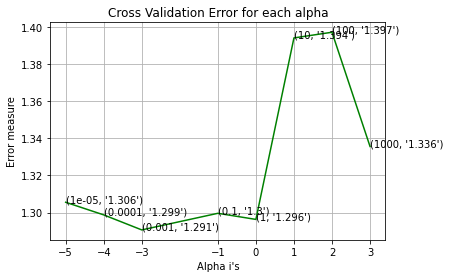

In [70]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_val, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [71]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.8148249371198318
For values of best alpha =  0.001 The cross validation log loss is: 1.290631514557274
For values of best alpha =  0.001 The test log loss is: 1.2521279978338253


4.1.1.2. Testing the model with best hyper paramters

Log Loss : 1.290631514557274
Number of missclassified point : 0.3966165413533835


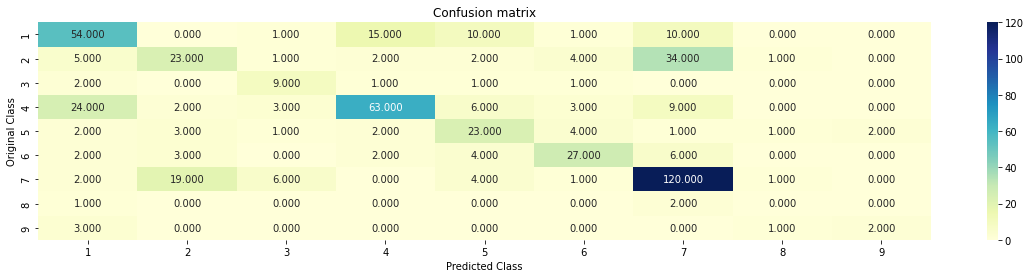

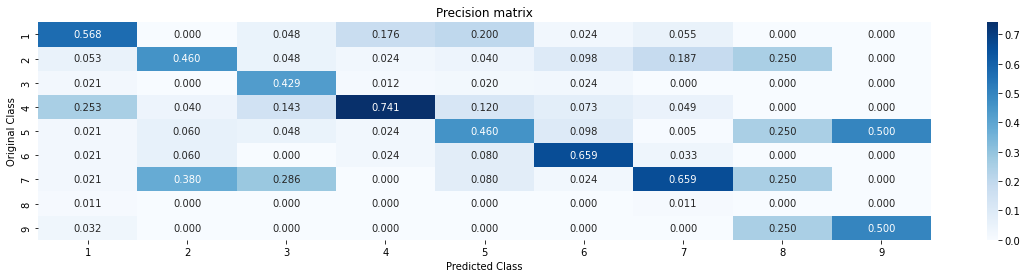

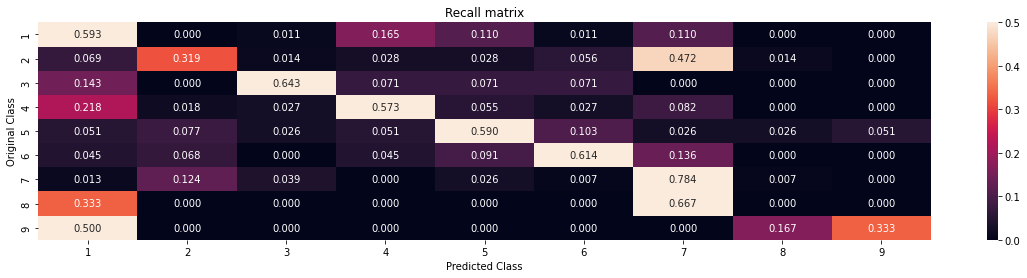

In [72]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(y_val, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- y_val))/y_val.shape[0])
plot_confusion_matrix(y_val, sig_clf.predict(cv_x_onehotCoding.toarray()))

4.1.1.3. Feature Importance, Correctly classified point

In [73]:
test_point_index = 10
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices=np.argsort(-1*clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.5784 0.0847 0.0131 0.1099 0.0426 0.0404 0.1205 0.005  0.0053]]
Actual Class : 4
--------------------------------------------------
15 Text feature [function] present in test data point [True]
16 Text feature [one] present in test data point [True]
17 Text feature [two] present in test data point [True]
18 Text feature [protein] present in test data point [True]
19 Text feature [dna] present in test data point [True]
20 Text feature [type] present in test data point [True]
21 Text feature [sequence] present in test data point [True]
22 Text feature [affect] present in test data point [True]
23 Text feature [frameshift] present in test data point [True]
24 Text feature [loss] present in test data point [True]
25 Text feature [amino] present in test data point [True]
26 Text feature [wild] present in test data point [True]
27 Text feature [reduced] present in test data point [True]
28 Text feature [binding] present in test data point 

In [74]:
X_test['Text'].iloc[test_point_index]

'tuberous sclerosis complex tsc autosomal dominant disorder characterized development hamartomas variety organs tissues including brain skin kidneys roach et al 1999 mutations either tsc1 gene chromosome 9q34 mim 605284 van slegtenhorst et al 1997 tsc2 gene chromosome 16p13 3 mim 191092 european consortium 1993 cause tsc 75 85 tsc cases definite germ line tsc1 tsc2 mutation identified whereas another 5 10 cases absolutely clear genetic data whether change pathogenic neutral variant sancak et al 2005 tsc1 tsc2 gene products hamartin tsc1 tuberin tsc2 interact form protein complex van slegtenhorst et al 1998 tsc1 important maintaining stability activity correct intracellular localization tsc1 tsc2 complex benvenuto et al 2000 cai et al 2006 chong kopera et al 2006 n terminal region tsc2 amino acids 1 900 mediates interaction tsc1 hoogeveen westerveld et al 2011 nellist et al 2001 amino acids 1 525 1 770 c terminal region tsc2 form asparagine thumb gtpase activating protein gap domain dau

In [75]:
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
indices[0]

array([    0, 37365, 37366, 16719, 37367, 37368, 37370, 37371, 16713,
       16711, 37374, 37380, 37382, 37384, 37385, 37389, 37390, 16702,
       37392, 37394, 16722, 16699, 37364, 37362, 16750, 37329, 37330,
       37331, 37334, 37337, 37340, 37343, 37346, 16738, 37355, 37356,
       16733, 37357, 16731, 37358, 16729, 37359, 37361, 37363, 37396,
       16697, 37397, 37439, 37441, 37442, 16660, 37443, 37445, 37446,
       37449, 16654, 37452, 16652, 37453, 16650, 37455, 37456, 37459,
       37460, 16644, 37461, 16664, 37435, 37432, 37430, 16695, 16694,
       16693, 16692, 37401, 16689, 37407, 37408, 37410, 37327, 16685,
       16682, 16681, 16680, 37413, 37414, 37416, 16673, 16672, 37418,
       16684, 16642, 16753, 37323, 16841, 37191, 37194, 16837, 16835,
       37196])

In [76]:
for i in range(2):
    test_point_index = np.random.randint(0, len(X_test))
    no_feature = 100
    predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
    print("Index : ", test_point_index)
    print("Predicted Class :", predicted_cls[0])
    print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
    print("Actual Class :", y_test[test_point_index])
    indices=np.argsort(-1*clf.coef_)[predicted_cls-1][:,:no_feature]
    print("-"*50)
    get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)


Index :  142
Predicted Class : 4
Predicted Class Probabilities: [[0.0712 0.0698 0.0109 0.6719 0.0351 0.0333 0.0993 0.0042 0.0044]]
Actual Class : 4
--------------------------------------------------
9 Text feature [function] present in test data point [True]
10 Text feature [protein] present in test data point [True]
14 Text feature [mammalian] present in test data point [True]
15 Text feature [activity] present in test data point [True]
16 Text feature [missense] present in test data point [True]
17 Text feature [proteins] present in test data point [True]
18 Text feature [experiments] present in test data point [True]
19 Text feature [acid] present in test data point [True]
21 Text feature [functional] present in test data point [True]
22 Text feature [amino] present in test data point [True]
23 Text feature [abrogate] present in test data point [True]
24 Text feature [retained] present in test data point [True]
25 Text feature [results] present in test data point [True]
26 Text feat

## 4.2. K Nearest Neighbour Classification

>4.2.1. Hyper parameter tuning

In [77]:
from sklearn.neighbors import KNeighborsClassifier

for alpha = 2
Log Loss : 1.007221976940907
for alpha = 3
Log Loss : 1.0087262570237145
for alpha = 5
Log Loss : 1.0228164822250807
for alpha = 11
Log Loss : 1.032284551970329
for alpha = 15
Log Loss : 1.041934942097953
for alpha = 21
Log Loss : 1.0690048396118201
for alpha = 31
Log Loss : 1.0707723253416503
for alpha = 41
Log Loss : 1.078891807991814
for alpha = 51
Log Loss : 1.093174130875928
for alpha = 99
Log Loss : 1.1400019413531046


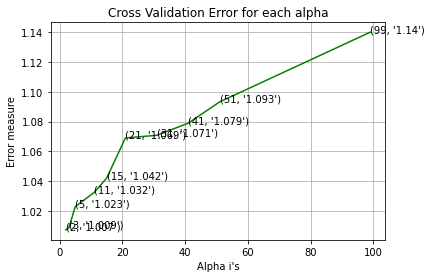

In [78]:
neighbour = [2, 3, 5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in neighbour:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_val, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(neighbour, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((neighbour[i],str(txt)), (neighbour[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()



In [79]:
best_neigh = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=neighbour[best_neigh])
clf.fit(train_x_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', neighbour[best_neigh], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', neighbour[best_neigh], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', neighbour[best_neigh], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  2 The train log loss is: 0.29906933180832895
For values of best alpha =  2 The cross validation log loss is: 1.007221976940907
For values of best alpha =  2 The test log loss is: 0.9608600071682825


### 4.2.2. Testing the model with best hyper paramters

Log loss : 1.007221976940907
Number of mis-classified points : 0.3233082706766917


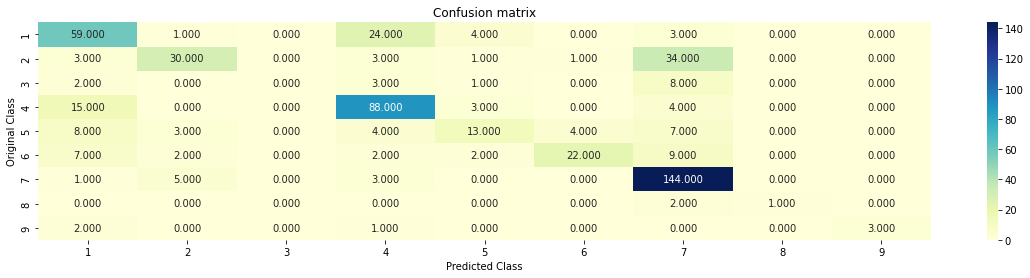

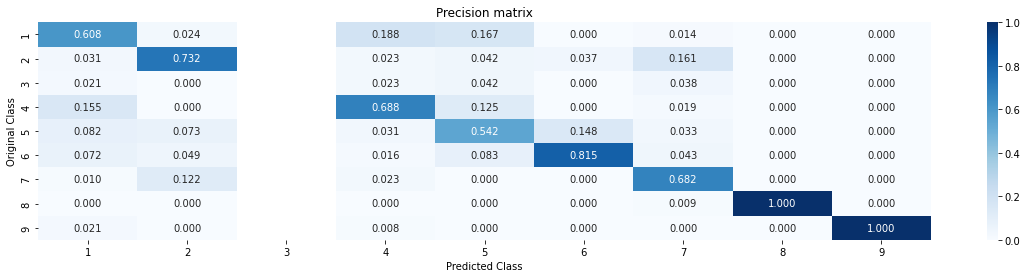

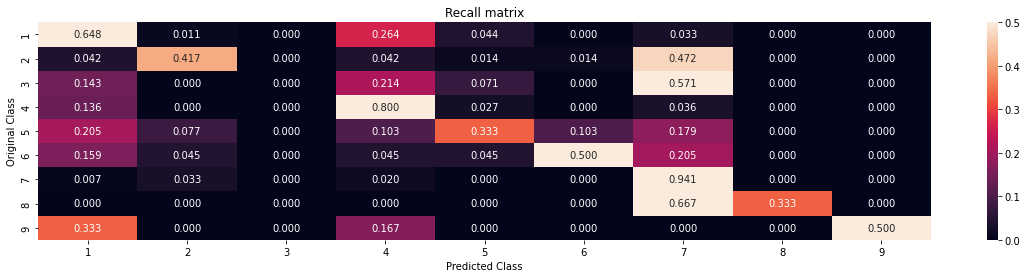

In [80]:
clf = KNeighborsClassifier(n_neighbors=neighbour[best_neigh])
predict_and_plot_confusion_matrix(train_x_responseCoding, y_train, cv_x_responseCoding, y_val, clf)

### 4.2.3.Sample Query point -1

In [81]:
test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), neighbour[best_neigh])
print("The ",neighbour[best_neigh]," nearest neighbours of the test points belongs to classes",y_train[neighbors[1][0]])
print("Fequency of nearest points :",Counter(y_train[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 2
The  2  nearest neighbours of the test points belongs to classes [7 7]
Fequency of nearest points : Counter({7: 2})


In [82]:
clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), neighbour[best_neigh])

(array([[0.03361486, 0.03689035]]), array([[1136, 2039]]))

### 4.2.4. Sample Query Point-2

In [83]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), neighbour[best_neigh])
print("The ",neighbour[best_neigh]," nearest neighbours of the test points belongs to classes",y_train[neighbors[1][0]])
print("Fequency of nearest points :",Counter(y_train[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 4
The  2  nearest neighbours of the test points belongs to classes [4 4]
Fequency of nearest points : Counter({4: 2})


## 4.3. Logistic Regression

### 4.3.1. With Class balancing

for alpha = 1e-06
Log Loss : 1.3337167074004723
for alpha = 1e-05
Log Loss : 1.2990430807746811
for alpha = 0.0001
Log Loss : 1.1003104330420936
for alpha = 0.001
Log Loss : 1.0572765805432567
for alpha = 0.01
Log Loss : 1.1399869213975915
for alpha = 0.1
Log Loss : 1.436654480992448
for alpha = 1
Log Loss : 1.6853117041988743
for alpha = 10
Log Loss : 1.715312702833443
for alpha = 100
Log Loss : 1.7184752089972075


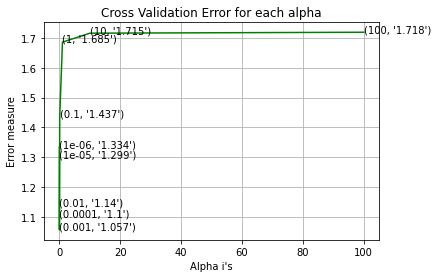

In [84]:
# 4.3.1.1. Hyper paramter tuning

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


In [85]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5149720929969103
For values of best alpha =  0.001 The cross validation log loss is: 1.0572765805432567
For values of best alpha =  0.001 The test log loss is: 1.0782563940694336


4.3.1.2. Testing the model with best hyper paramters

Log loss : 1.0572765805432567
Number of mis-classified points : 0.34962406015037595


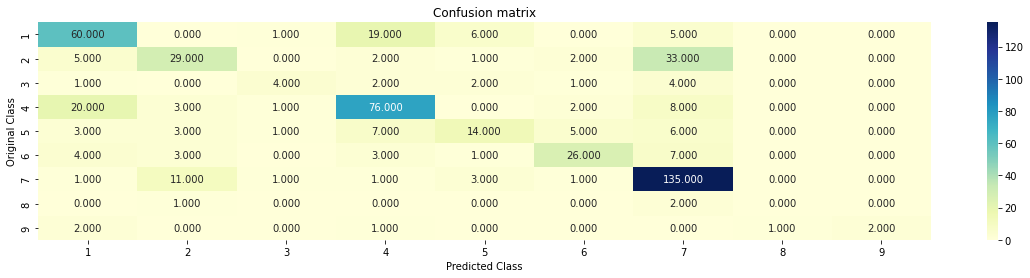

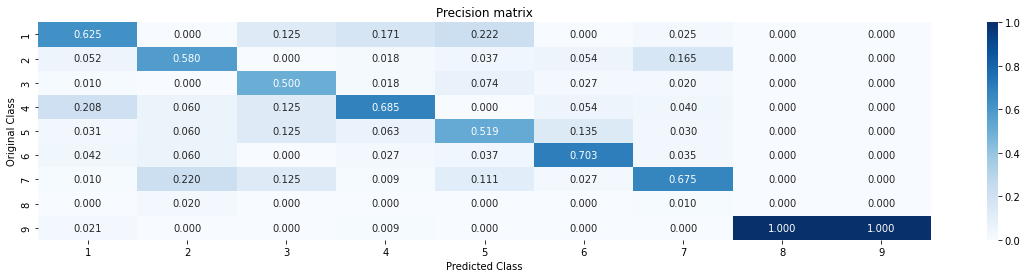

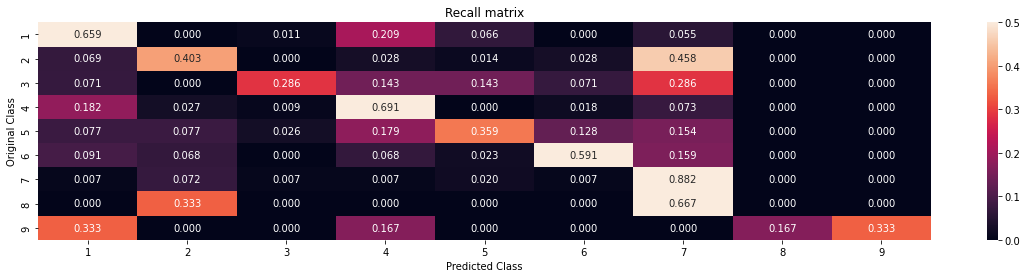

In [86]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, y_train, cv_x_onehotCoding, y_val, clf)

4.3.1.3. Feature Importance

In [89]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

### 4.3.1.3.1. Correctly Classified point

In [92]:
from tabulate import tabulate
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[3.200e-03 2.400e-03 7.000e-04 9.833e-01 1.800e-03 3.000e-04 3.200e-03
  3.600e-03 1.400e-03]]
Actual Class : 4
--------------------------------------------------
159 Text feature [activating] present in test data point [True]
246 Text feature [nonidet] present in test data point [True]
334 Text feature [coa] present in test data point [True]
348 Text feature [truncate] present in test data point [True]
451 Text feature [potential] present in test data point [True]
459 Text feature [inhibitor] present in test data point [True]
470 Text feature [independent] present in test data point [True]
487 Text feature [kinase] present in test data point [True]
489 Text feature [acetylation] present in test data point [True]
Out of the top  500  features  9 are present in query point


### 4.3.1.3.2. Incorrectly Classified point


In [91]:
from tabulate import tabulate
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[1.400e-03 1.061e-01 6.000e-04 8.000e-04 4.800e-03 6.000e-04 8.809e-01
  3.500e-03 1.300e-03]]
Actual Class : 2
--------------------------------------------------
89 Text feature [constitutive] present in test data point [True]
96 Text feature [transforming] present in test data point [True]
116 Text feature [3t3] present in test data point [True]
146 Text feature [nonsense] present in test data point [True]
148 Text feature [missense] present in test data point [True]
159 Text feature [activated] present in test data point [True]
174 Text feature [nude] present in test data point [True]
186 Text feature [ligand] present in test data point [True]
188 Text feature [agar] present in test data point [True]
193 Text feature [acceptor] present in test data point [True]
198 Text feature [subcutaneously] present in test data point [True]
203 Text feature [constitutively] present in test data point [True]
204 Text feature [pharma] present in 

## 4.3.2. Without Class balancing

#### 4.3.2.1. Hyper paramter tuning

for alpha = 1e-06
Log Loss : 1.3157902174518648
for alpha = 1e-05
Log Loss : 1.264935725003557
for alpha = 0.0001
Log Loss : 1.1115582980141294
for alpha = 0.001
Log Loss : 1.0780809733839691
for alpha = 0.01
Log Loss : 1.1991511578678087
for alpha = 0.1
Log Loss : 1.3866427520711804
for alpha = 1
Log Loss : 1.6190312228100507
for alpha = 10
Log Loss : 1.6563076267873145
for alpha = 100
Log Loss : 1.660243410274481


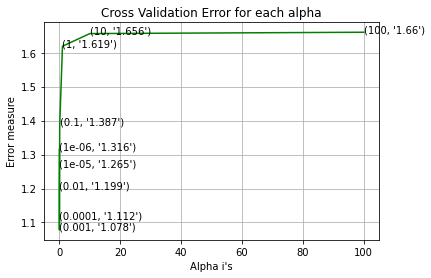

In [93]:


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


In [94]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5092235035379327
For values of best alpha =  0.001 The cross validation log loss is: 1.0780809733839691
For values of best alpha =  0.001 The test log loss is: 1.0815092433406466


### 4.3.2.2. Testing the model with best hyper paramters

Log loss : 1.0780809733839691
Number of mis-classified points : 0.34962406015037595


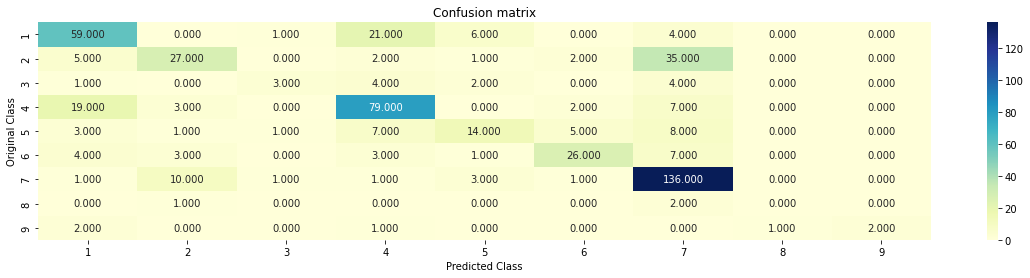

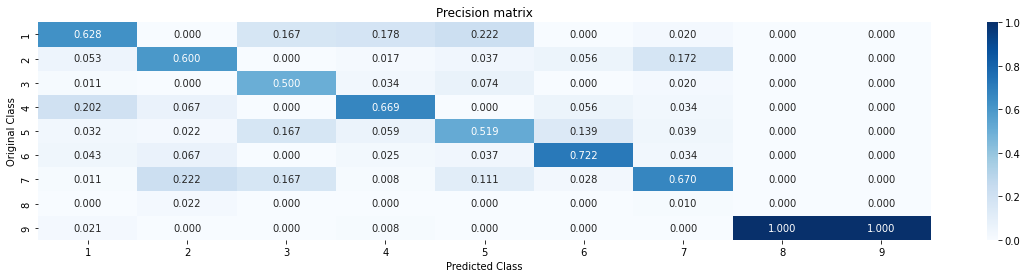

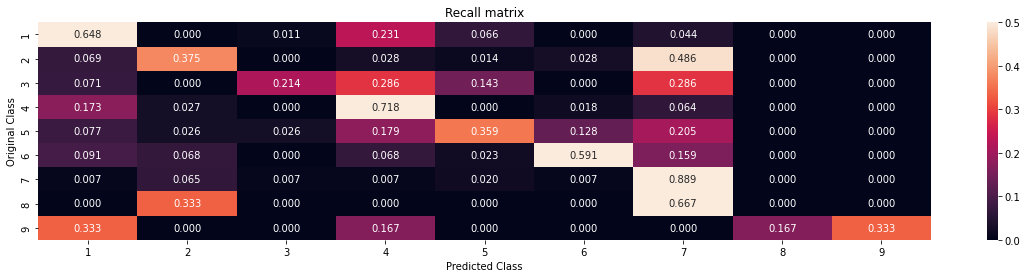

In [95]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, y_train, cv_x_onehotCoding, y_val, clf)

### 4.3.2.3. Feature Importance, Correctly Classified point

In [96]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[3.700e-03 2.600e-03 5.000e-04 9.828e-01 1.500e-03 2.000e-04 4.700e-03
  3.800e-03 0.000e+00]]
Actual Class : 4
--------------------------------------------------
290 Text feature [activating] present in test data point [True]
298 Text feature [truncate] present in test data point [True]
341 Text feature [nonidet] present in test data point [True]
396 Text feature [coa] present in test data point [True]
457 Text feature [acetylation] present in test data point [True]
Out of the top  500  features  5 are present in query point


### 4.3.2.4. Feature Importance, Inorrectly Classified point


In [97]:
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[1.600e-03 1.166e-01 4.000e-04 1.000e-03 3.800e-03 5.000e-04 8.721e-01
  3.800e-03 0.000e+00]]
Actual Class : 2
--------------------------------------------------
135 Text feature [transforming] present in test data point [True]
181 Text feature [constitutive] present in test data point [True]
192 Text feature [3t3] present in test data point [True]
249 Text feature [agar] present in test data point [True]
280 Text feature [ligand] present in test data point [True]
288 Text feature [activated] present in test data point [True]
301 Text feature [constitutively] present in test data point [True]
310 Text feature [pharma] present in test data point [True]
322 Text feature [nude] present in test data point [True]
337 Text feature [selleck] present in test data point [True]
386 Text feature [subcutaneously] present in test data point [True]
392 Text feature [nonsense] present in test data point [True]
397 Text feature [activating] present 

## 4.4. Linear Support Vector Machines

#### 4.4.1. Hyper paramter tuning

for alpha = 1e-06
Log Loss : 1.3276194992687596
for alpha = 1e-05
Log Loss : 1.296537369559356
for alpha = 0.0001
Log Loss : 1.2235013643963206
for alpha = 0.001
Log Loss : 1.1151741474957837
for alpha = 0.01
Log Loss : 1.1283787818700968
for alpha = 0.1
Log Loss : 1.3366676443619994
for alpha = 1
Log Loss : 1.7029105040745751
for alpha = 10
Log Loss : 1.7190300572780282
for alpha = 100
Log Loss : 1.7190300647548316


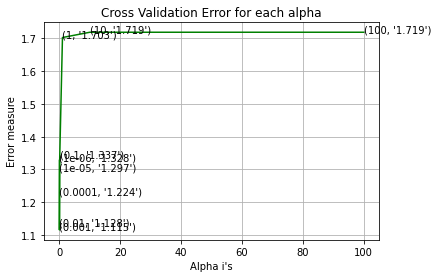

In [98]:
# 4.3.1.1. Hyper paramter tuning

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


In [99]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5227078179539113
For values of best alpha =  0.001 The cross validation log loss is: 1.1151741474957837
For values of best alpha =  0.001 The test log loss is: 1.1621851787944713


## 4.4.2. Testing the model with best hyper parameters

Log loss : 1.1151741474957837
Number of mis-classified points : 0.35902255639097747


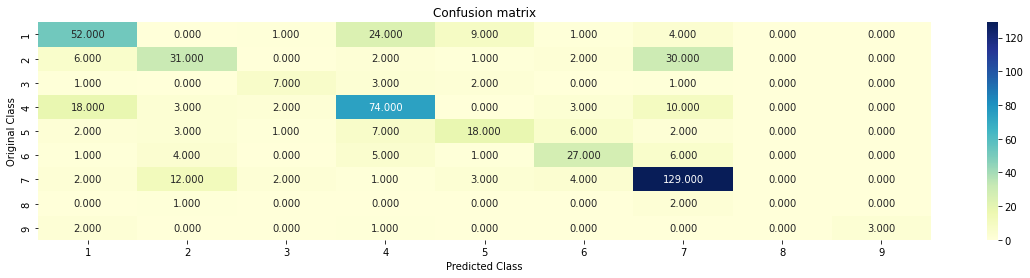

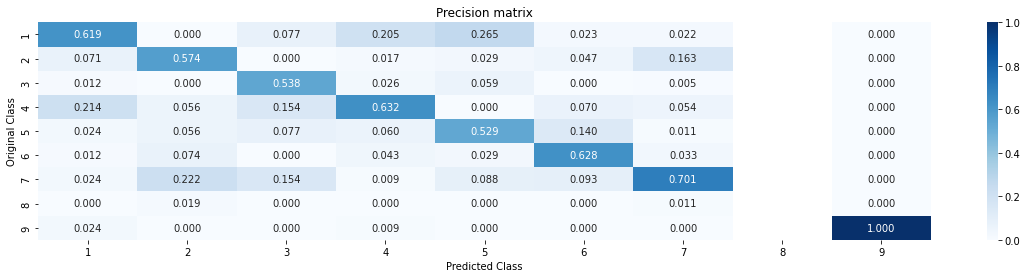

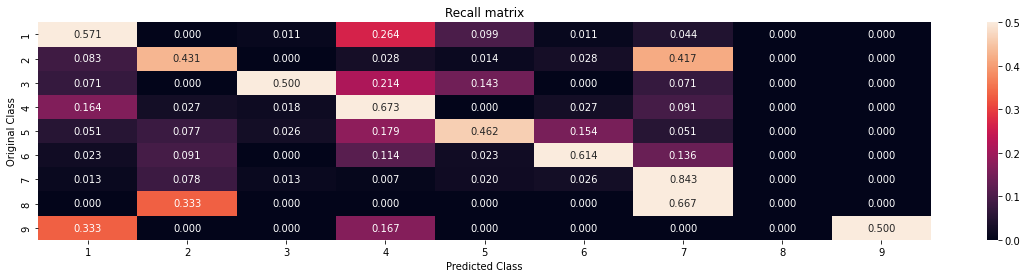

In [100]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, y_train, cv_x_onehotCoding, y_val, clf)

## 4.3.3. Feature Importance

### 4.3.3.1. For Correctly classified point

### 4.3.1.3.1. Correctly Classified point

In [101]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[1.790e-02 1.250e-02 7.100e-03 9.107e-01 1.530e-02 8.000e-04 2.680e-02
  3.600e-03 5.300e-03]]
Actual Class : 4
--------------------------------------------------
Out of the top  500  features  0 are present in query point


### 4.3.1.3.2. Incorrectly Classified point


In [102]:
from tabulate import tabulate
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0351 0.1651 0.0051 0.0283 0.0149 0.0074 0.736  0.0034 0.0046]]
Actual Class : 2
--------------------------------------------------
139 Text feature [transforming] present in test data point [True]
461 Text feature [3t3] present in test data point [True]
Out of the top  500  features  2 are present in query point


## 4.5 Random Forest Classifier

### 4.5.1. Hyper paramter tuning (With One hot Encoding)

In [112]:

alpha = [100,200,500,1000]
max_depth = [5, 10]
cv_log_error_array = []
for i in tqdm(alpha):
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, y_train)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_val, sig_clf_probs)) 


  0%|          | 0/4 [00:00<?, ?it/s]

for n_estimators = 100 and max depth =  5
Log Loss : 1.2529125170729252
for n_estimators = 100 and max depth =  10


 25%|██▌       | 1/4 [00:20<01:02, 20.83s/it]

Log Loss : 1.2077642392847772
for n_estimators = 200 and max depth =  5
Log Loss : 1.2435458723815018
for n_estimators = 200 and max depth =  10


 50%|█████     | 2/4 [00:55<00:57, 28.95s/it]

Log Loss : 1.1961475511781003
for n_estimators = 500 and max depth =  5
Log Loss : 1.2410465113297022
for n_estimators = 500 and max depth =  10


 75%|███████▌  | 3/4 [02:14<00:51, 51.95s/it]

Log Loss : 1.187826409090982
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2434859257756183
for n_estimators = 1000 and max depth =  10


100%|██████████| 4/4 [04:39<00:00, 69.85s/it]

Log Loss : 1.1866718775806584


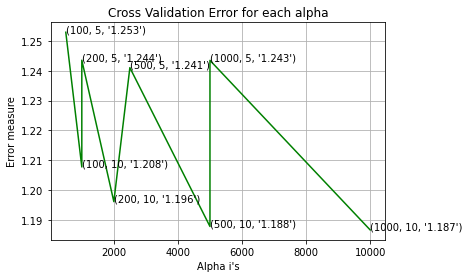

In [113]:
fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [115]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best estimator =  1000 The train log loss is: 0.6709245711733682
For values of best estimator =  1000 The cross validation log loss is: 1.1866718775806584
For values of best estimator =  1000 The test log loss is: 1.1272233433236363


### 4.5.2. Testing model with best hyper parameters (One Hot Encoding)

Log loss : 1.1866718775806584
Number of mis-classified points : 0.40037593984962405


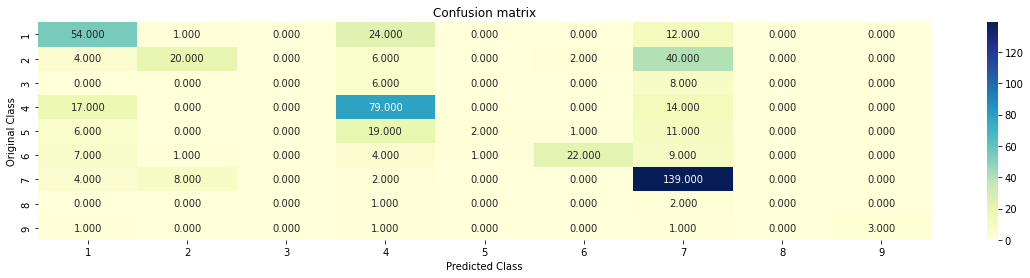

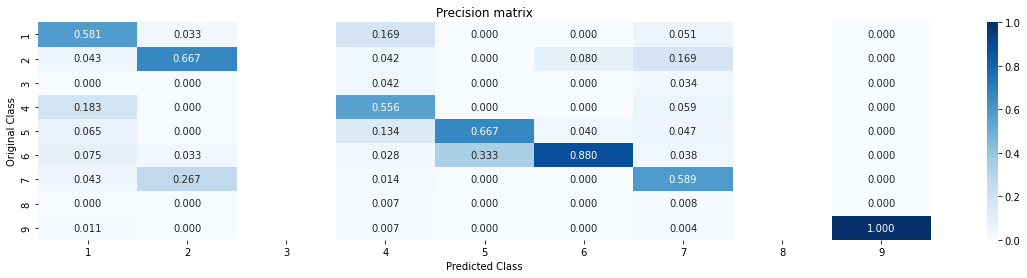

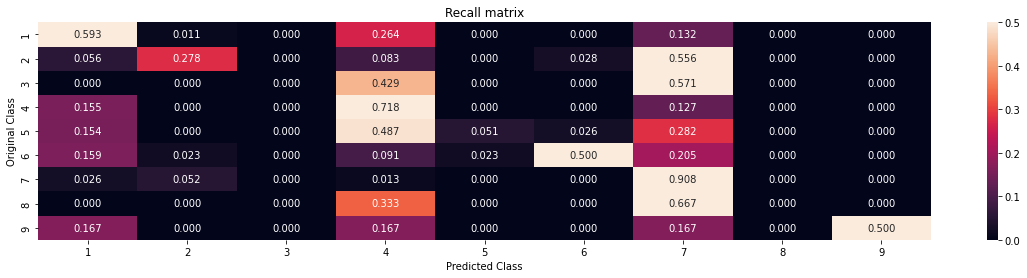

In [116]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, y_train,cv_x_onehotCoding,y_val, clf)

### 4.5.3. Feature Importance

#### 4.5.3.1. Correctly Classified point

In [118]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.3402 0.0554 0.0217 0.3576 0.0525 0.0466 0.1038 0.0138 0.0085]]
Actual Class : 4
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
2 Text feature [phosphorylation] present in test data point [True]
3 Text feature [activation] present in test data point [True]
4 Text feature [missense] present in test data point [True]
5 Text feature [activated] present in test data point [True]
6 Text feature [inhibitors] present in test data point [True]
7 Text feature [suppressor] present in test data point [True]
8 Text feature [function] present in test data point [True]
9 Text feature [activating] present in test data point [True]
10 Text feature [nonsense] present in test data point [True]
11 Text feature [therapy] present in test data point [True]
12 Text feature [inhibitor] present in test data point [True]
13 Text feature [frameshift] present in test data point [True]
15 Text featur

#### 4.5.3.2. Inorrectly Classified point

In [119]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.046  0.1143 0.0174 0.036  0.0396 0.0346 0.7022 0.0047 0.005 ]]
Actual Class : 2
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [tyrosine] present in test data point [True]
2 Text feature [phosphorylation] present in test data point [True]
3 Text feature [activation] present in test data point [True]
4 Text feature [missense] present in test data point [True]
5 Text feature [activated] present in test data point [True]
6 Text feature [inhibitors] present in test data point [True]
7 Text feature [suppressor] present in test data point [True]
8 Text feature [function] present in test data point [True]
9 Text feature [activating] present in test data point [True]
10 Text feature [nonsense] present in test data point [True]
11 Text feature [therapy] present in test data point [True]
12 Text feature [inhibitor] present in test data point [True]
14 Text feature [

## 4.5.4. Hyper paramter tuning (With Response Coding)

In [120]:
alpha = [100,200,500,1000]
max_depth = [5, 10, 15]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, y_train)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_val, sig_clf_probs)) 

for n_estimators = 100 and max depth =  5
Log Loss : 0.1296291510683821
for n_estimators = 100 and max depth =  10
Log Loss : 0.10332257992327387
for n_estimators = 100 and max depth =  15
Log Loss : 0.10155349461144543
for n_estimators = 200 and max depth =  5
Log Loss : 0.12091505069395193
for n_estimators = 200 and max depth =  10
Log Loss : 0.10183620660718623
for n_estimators = 200 and max depth =  15
Log Loss : 0.10127695051326477
for n_estimators = 500 and max depth =  5
Log Loss : 0.11993091025629114
for n_estimators = 500 and max depth =  10
Log Loss : 0.10315531104790915
for n_estimators = 500 and max depth =  15
Log Loss : 0.10195449879063354
for n_estimators = 1000 and max depth =  5
Log Loss : 0.11965632647549125
for n_estimators = 1000 and max depth =  10
Log Loss : 0.10277656079380229
for n_estimators = 1000 and max depth =  15
Log Loss : 0.10171054672075283


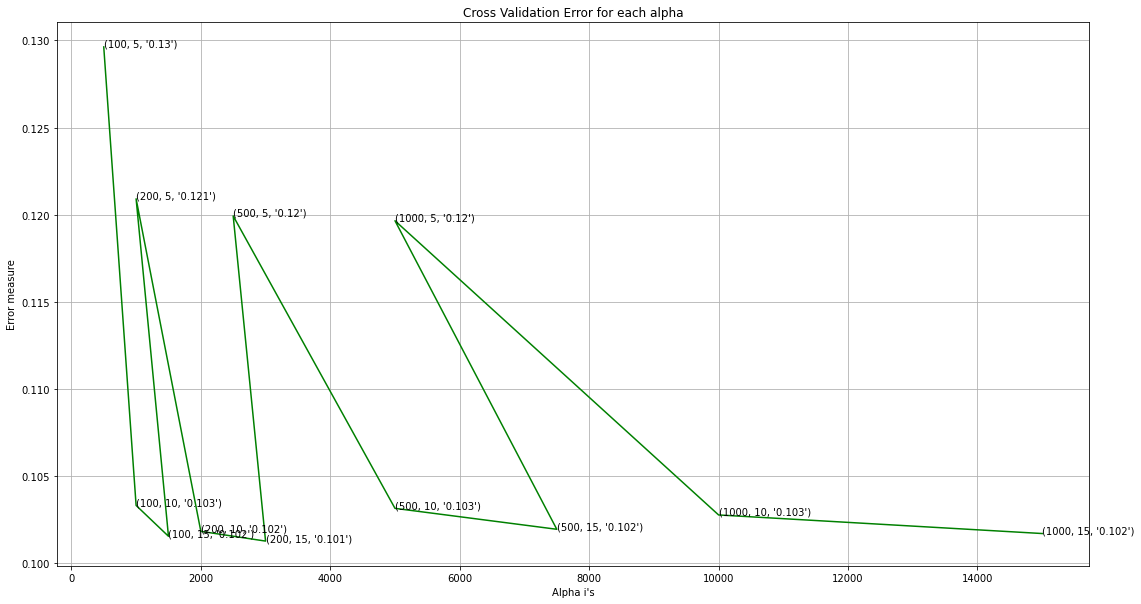

In [129]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10)
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/3)],max_depth[int(i%3)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [130]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/3)], criterion='gini', max_depth=max_depth[int(best_alpha%3)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/3)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/3)], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/3)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  200 The train log loss is: 0.036908000534504486
For values of best alpha =  200 The cross validation log loss is: 0.10127695051326477
For values of best alpha =  200 The test log loss is: 0.0668048413996291


### 4.5.4.2. Testing model with best hyper parameters (Response Coding)

Log loss : 0.10183620660718624
Number of mis-classified points : 0.020676691729323307


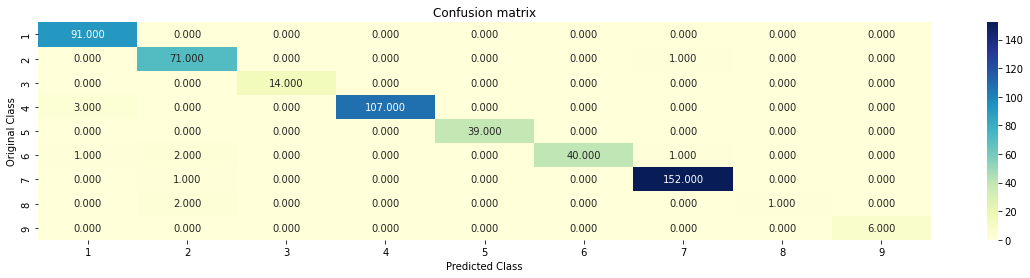

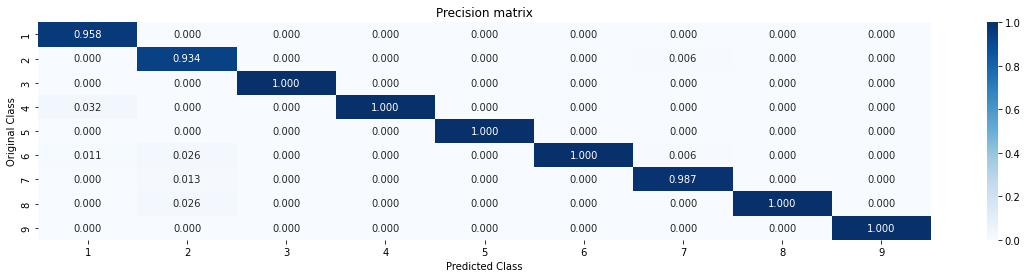

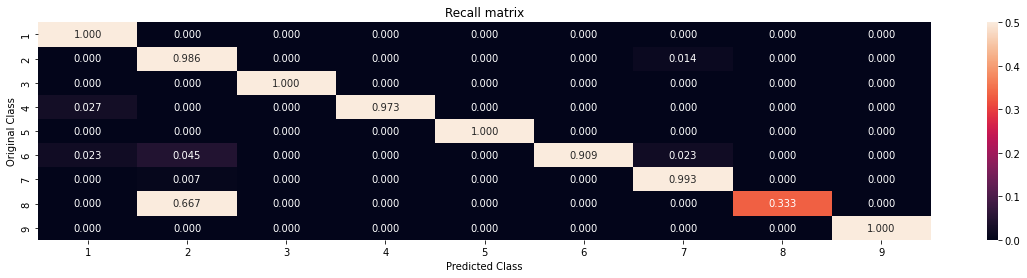

In [131]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, y_train,cv_x_responseCoding,y_val, clf)

### 4.5.5. Feature Importance

#### 4.5.5.1. Correctly Classified point

In [148]:
test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)

for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")



Predicted Class : 2
Predicted Class Probabilities: [[0.0047 0.9681 0.0028 0.0054 0.0033 0.0047 0.0047 0.0029 0.0034]]
Actual Class : 2
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature


#### 4.5.3.2. Inorrectly Classified point

In [149]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)


#for i in indices:
#    if i<9:
#        print("Gene is important feature")
#    elif i<18:
#        print("Variation is important feature")
#    else:
#        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.0047 0.9681 0.0028 0.0054 0.0033 0.0047 0.0047 0.0029 0.0034]]
Actual Class : 2
--------------------------------------------------


## 4.7 Stack the models

### 4.7.1 testing with hyper parameter tuning

In [158]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, y_train)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, y_train)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(y_val, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, y_train)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(y_val, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, y_train)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(y_val, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))


Logistic Regression :  Log Loss: 1.06
Support vector machines : Log Loss: 1.70
Naive Bayes : Log Loss: 1.29
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.818
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.722
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.329
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.180
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.457
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.829


Log loss (train) on the stacking classifier : 0.4854959068819575
Log loss (CV) on the stacking classifier : 1.1800815992555653
Log loss (test) on the stacking classifier : 1.166501956435722
Number of missclassified point : 0.3548872180451128


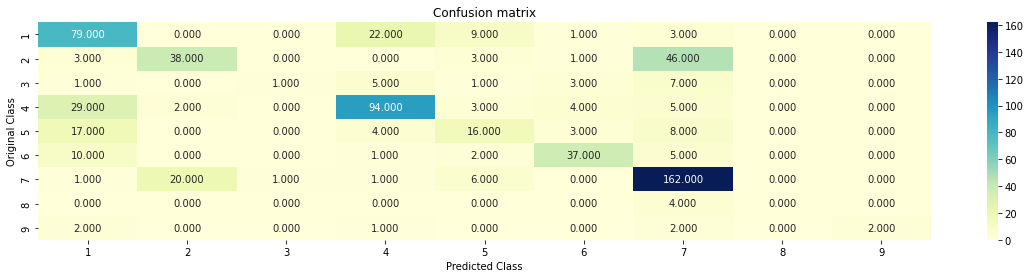

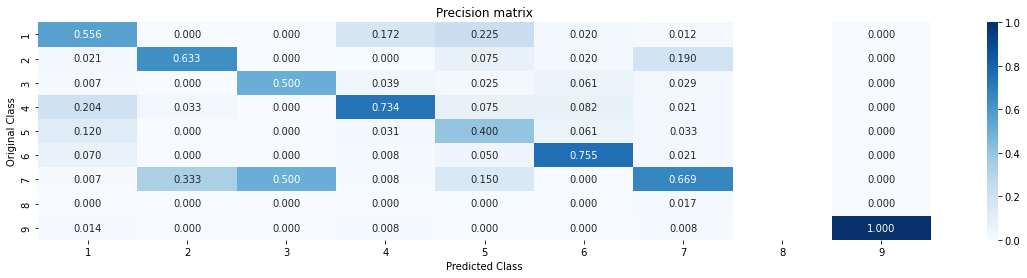

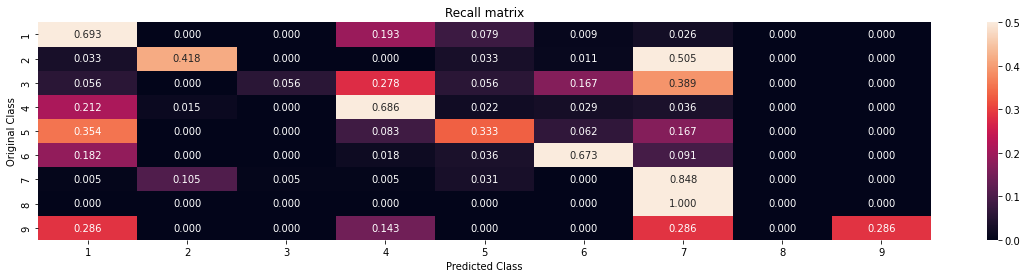

In [159]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, y_train)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- y_test))/y_test.shape[0])
plot_confusion_matrix(test_y=y_test, predict_y=sclf.predict(test_x_onehotCoding))

### 4.7.3 Maximum Voting classifier

Log loss (train) on the VotingClassifier : 0.8529309354880348
Log loss (CV) on the VotingClassifier : 1.1991811885755594
Log loss (test) on the VotingClassifier : 1.1856039547868165
Number of missclassified point : 0.34135338345864663


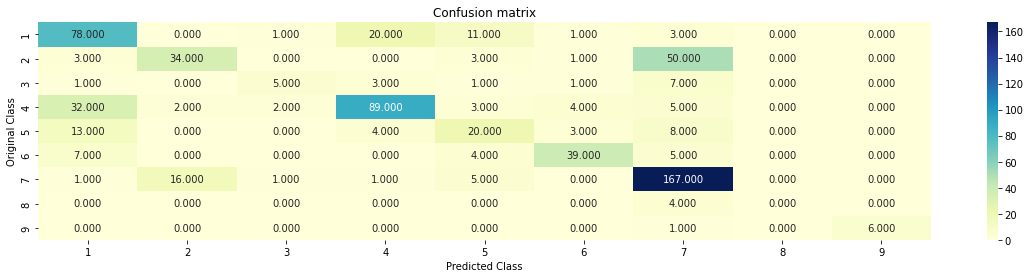

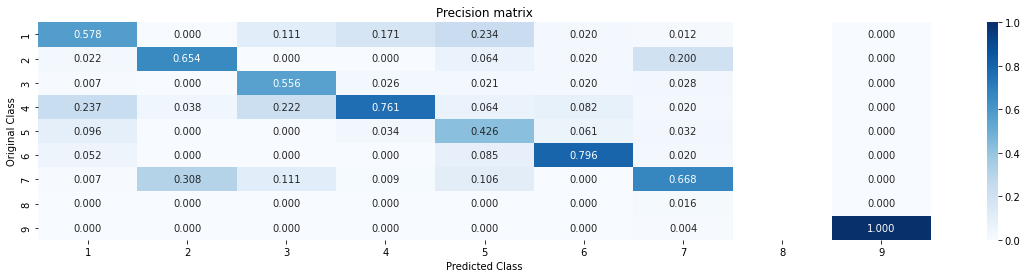

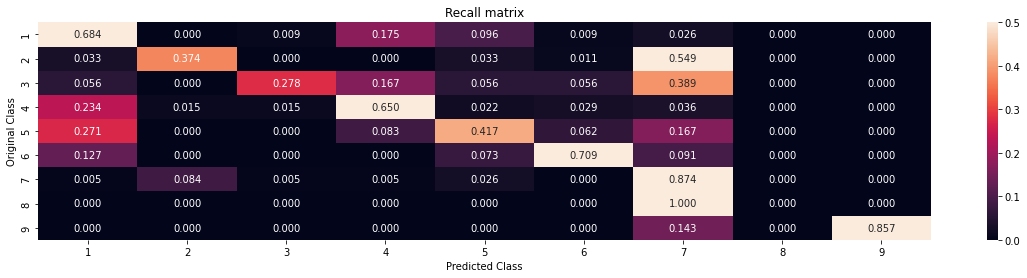

In [160]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, y_train)
print("Log loss (train) on the VotingClassifier :", log_loss(y_train, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(y_val, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(y_test, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- y_test))/y_test.shape[0])
plot_confusion_matrix(test_y=y_test, predict_y=vclf.predict(test_x_onehotCoding))

In [161]:
np.save("X_train.npy",X_train)
np.save("X_test.npy", X_test)
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)